# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제  - Tobigs 15기 이성범
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결

In [1]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

## 패키지 임포트

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [3]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 데이터 확인하기

In [4]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


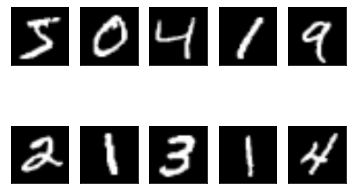

In [5]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [6]:
# dataloader
batch_size = 128 # 본 논문에서 batch_size를 128로 설정함
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [7]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 신경망 

In [8]:
# 네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images
nz = 100 # size of z latent vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator

### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [9]:
'''
논문과 동일하게 가중치를 zero-centered 정규 분포로 표준 편차 0.02로 초기화
'''

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [10]:
class Generator(nn.Module):
    def __init__(self):

        '''
        기존 Conv2d라는 Convolutional layer가 이미지의 정보를 함축시킨다고 한다면
        ConvTranspose2d는 Convolutional layer가 하는 일의 반대의 일을 한다고 할 수 있다.
        함축되었던 이마지에 대한 정보를 기존의 이미지 형태로 만들어내는 일을 한다.

        nc = 1 # number of channels in the training images
        nz = 100 # size of z latent vector
        ngf = 64 # size of feature maps in generator
        ndf = 64 # size of feature maps in discriminator

        Generator는 새로운 이미지를 생성하는 일을 한다.

        Discriminator와 반대의 방식으로 layer를 쌓음

        ConvTranspose2d -> BatchNorm2d -> ReLU
        마지막 layer에 대해서만 BatchNorm2d을 사용하지 않고 Tanh을 사용
        channel의 경우 1/2씩 줄여나감
        '''

        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input = 100 x 1 x 1
            # in_channels = 100, out_channels = 64 * 8
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            # in_channels = 64 * 8, out_channels = 64 * 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            # in_channels = 64 * 4, out_channels = 64 * 2
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            # in_channels = 64 * 2, out_channels = 64
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            # in_channels = 64, out_channels = 1
            nn.ConvTranspose2d(in_channels = ngf, out_channels = nc, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.Tanh()
            
            # output = 1 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 판별자 클래스

In [12]:
class Discriminator(nn.Module):
    def __init__(self):

        '''
        nc = 1 # number of channels in the training images
        nz = 100 # size of z latent vector
        ngf = 64 # size of feature maps in generator
        ndf = 64 # size of feature maps in discriminator

        Discriminator는 들어온 이미지를 가짜인지 진짜인지 판별하는 일을 한다.

        Generator와 반대의 방식으로 layer를 쌓음

        Conv2d -> BatchNorm2d -> LeakyReLU
        마지막 layer의 경우 BCE를 사용하기 위해서 Sigmoid를 사용
        channel의 경우 2배씩 늘여나감
        '''

        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input = 1 x 64 x 64
            # in_channels = 1, out_channels = 64
            nn.Conv2d(in_channels = nc, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            # in_channels = 64, out_channels = 64 * 2
            nn.Conv2d(in_channels = ndf, out_channels = ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            # in_channels = 64 * 2, out_channels = 64 * 4
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            # in_channels = 64 * 4, out_channels = 64 * 8
            nn.Conv2d(in_channels = ndf * 4, out_channels = ndf * 8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            # in_channels = 64 * 8, out_channels = 1
            nn.Conv2d(in_channels = ndf * 8, out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.Sigmoid()

            # output = 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

In [13]:
netD = Discriminator().to(device) # 판별자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function & Optimizer

In [14]:
# 손실함수
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

# optimizer hyperparameters
learning_rate = 0.0002 # lr의 경우 본 논문에서 0.001은 너무 커 학습이 불안정하여 0.0002로 설정하였다함
beta1 = 0.5 # 본 논문에서 beta1을 0.9로 두었을 때 학습이 불안정하여 0.5로 설정하였다함

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999)) # 판별자의 optimizer
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999)) # 생성자의 optimizer

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [15]:
num_epochs = 5

for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):

        # Discriminator 학습
        # MNIST 이미지로 학습 (진짜)
        netD.zero_grad() # 기울기 초기화
        real_cpu = data[0].to(device) # 진짜 이미지 데이터 -> [128, 1, 64, 64]
        b_size = real_cpu.size(0) # batch_size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # batch_size만큼 들어온 데이터에 대하여 진짜 이미지라는 뜻의 라벨 부착 -> Discriminator가 진짜 이미지를 진짜로 판단하고자
        output = netD(real_cpu).view(-1) # 진짜 이미지에 대한 확률 값 출력
        errD_real = criterion(output, label) # 진짜 이미지에 대한 output과 1 label(진짜 이미지를 의미)에 대한 손실함수 출력
        errD_real.backward() # 역전파
        D_x = output.mean().item() # 진짜 이미지에 대한 output의 평균 확률 값

        # Generator가 생성한 이미지로 학습 (가짜)
        noise = torch.randn(b_size, nz, 1, 1, device=device) # [128, 100, 1, 1] 크기를 가지는 noise 생성
        fake = netG(noise) # noise를 바탕으로 가짜 이미지 생성
        label.fill_(fake_label) # batch_size만큼 들어온 데이터에 대하여 가짜 이미지라는 뜻의 라벨 부착 -> Discriminator가 가짜 이미지를 가짜로 판단하고자
        output = netD(fake.detach()).view(-1) # 가짜 이미지에 대한 확률 값 출력
        errD_fake = criterion(output, label) # 가짜 이미지에 대한 output과 0 label(가짜 이미지를 의미)에 대한 손실함수 출력
        errD_fake.backward() # 역전파
        D_G_z1 = output.mean().item() # 가짜 이미지에 대한 output의 평균 확률 값

        errD = errD_real + errD_fake # 진짜, 가짜 이미지를 통해 구한 손실함수를 합침 -> 0에 가까울 수록 Discriminator가 판단을 잘함
        optimizerD.step() # 구한 손실함수를 바탕으로 Discriminator 최적화 진행

        # Generator 학습
        # Generator가 생성한 이미지로 학습 (가짜)
        netG.zero_grad() # 기울기 초기화
        label.fill_(real_label) # batch_size만큼 들어온 데이터에 대하여 진짜 이미지라는 뜻의 라벨 부착 -> Discriminator가 가짜 이미지를 진짜로 판단시키기 위해
        output = netD(fake).view(-1) # 가짜 이미지에 대한 확률 값 출력
        errG = criterion(output, label) # 가짜 이미지에 대한 output과 1 label(진짜 이미지를 의미)에 대한 손실함수 출력
        errG.backward() # 역전파
        D_G_z2 = output.mean().item() # 가짜 이미지에 대한 output의 평균 확률 값 -> 0에 가까울 수록 Discriminator가 판단을 못함

        optimizerG.step() # 구한 손실함수를 바탕으로 Generator 최적화 진행

        # 학습 경과 출력
        if i % 50 == 0:
            print(f'[{epoch + 1}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

[1/5][0/469]	Loss_D: 1.8449	Loss_G: 3.4829	D(x): 0.4138	D(G(z)): 0.4562 / 0.0466
[1/5][50/469]	Loss_D: 0.0615	Loss_G: 4.7867	D(x): 0.9761	D(G(z)): 0.0144 / 0.0138
[1/5][100/469]	Loss_D: 13.0762	Loss_G: 22.6982	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[1/5][150/469]	Loss_D: 0.1219	Loss_G: 4.4450	D(x): 0.9370	D(G(z)): 0.0461 / 0.0141
[1/5][200/469]	Loss_D: 0.1829	Loss_G: 2.4433	D(x): 0.8614	D(G(z)): 0.0174 / 0.1088
[1/5][250/469]	Loss_D: 0.2001	Loss_G: 3.0360	D(x): 0.8746	D(G(z)): 0.0358 / 0.0761
[1/5][300/469]	Loss_D: 0.1695	Loss_G: 3.2643	D(x): 0.9254	D(G(z)): 0.0770 / 0.0588
[1/5][350/469]	Loss_D: 0.3250	Loss_G: 0.9034	D(x): 0.7604	D(G(z)): 0.0085 / 0.4686
[1/5][400/469]	Loss_D: 0.1636	Loss_G: 3.7828	D(x): 0.9802	D(G(z)): 0.1259 / 0.0334
[1/5][450/469]	Loss_D: 0.2133	Loss_G: 3.3266	D(x): 0.9257	D(G(z)): 0.1179 / 0.0539
[2/5][0/469]	Loss_D: 0.1373	Loss_G: 3.2938	D(x): 0.9275	D(G(z)): 0.0554 / 0.0506
[2/5][50/469]	Loss_D: 0.5460	Loss_G: 3.2624	D(x): 0.9304	D(G(z)): 0.3390 / 0.0531
[2/5][10